# Web Scraping for Indeed.com & Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

## Predicting salaries using Logistic Regression

#### Load in the the data of scraped salaries

In [1]:
# libraries
import pandas as pd
import numpy as np

# Cleaning data

In [2]:
## YOUR CODE HERE
df=pd.read_csv('/Users/PatrickChen/Desktop/CSV FILES/indeed_data.csv',sep='\t')
df

,Unnamed: 0,title,company,location,salary,summary
0,0,Research Financial Analyst II,Baylor College of Medicine,"Houston, TX","$65,000 a year",\nUsing data from Principal Investigators and ...
1,1,Senior Predictive Modeling Actuary,Selby Jennings,"Houston, TX","$70,000 - $130,000 a year",\nSenior Predictive Modeler A leading global i...
2,2,Senior Data Scientist,Workbridge Associates,"Chicago, IL","$130,000 a year","\nStatistical modeling, predictive analysis, m..."
3,3,Director of Data Science,Workbridge Associates,"Chicago, IL","$180,000 a year","\nMid, Senior, Lead, Data, Scientist, Machine,..."
4,4,Data Scientist -Fitness/Wellness Firm,Hirewell,"Chicago, IL","$120,000 a year","\nExpertise in text mining, NLP methods, infor..."
5,5,Statistical Data Analyst- Long-term Contract i...,Modis,"Northbrook, IL 60062",$25 - $35 an hour,\nExperience with BI Analytics & Data Visualiz...
6,6,Statistical Analyst (part-time or full-time co...,Mission Measurement,"Chicago, IL 60601 (Loop area)",$20 an hour,"\nFor each area of social policy – e.g., educa..."
7,7,Data Scientist (Healthcare Data),Workbridge Associates,"Chicago, IL","$110,000 a year",\nA leading provider of healthcare analytics f...
8,8,Machine Learning Engineer,Jobspring Partners,"Chicago, IL","$100,000 - $120,000 a year",\nThis role is ideal for someone who has a str...
9,9,Quantitative Analyst,Silva Capital Management,"Chicago, IL 60611 (Near North Side area)","$125,000 a year","\nR, Python, VBA, Mat lab, C#). In Physics, En..."


In [3]:
# Clean up salary
df.salary.value_counts()
x = df.salary.str.split('-')

salary = []
for i in range(len(x)):
    salary.append(x[i][-1])
df.salary = salary

df = df[df.salary.str.contains("year")]

for i in df.salary.index:
    df.salary[i] = df.salary[i].replace(" a year", "")
    df.salary[i] = df.salary[i].replace("$", "")
    df.salary[i] = df.salary[i].replace(",", "")
    df.salary[i] = float(df.salary[i])

/Users/PatrickChen/anaconda/envs/dsienv/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/PatrickChen/anaconda/envs/dsienv/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/PatrickChen/anaconda/envs/dsienv/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Patr

In [4]:
# clean up locations
x = df.location.str.split(',')

loc = []
for i in df.location.index:
    loc.append(x[i][1][1:3])
df.location = loc

/Users/PatrickChen/anaconda/envs/dsienv/lib/python2.7/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [5]:
# drop dulicates
df = df.drop_duplicates(subset="summary")

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choice the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries, 

In [6]:
# give dummy variable to salary
salary_median = df.salary.median()
salary_dum = []
for salary in df.salary:
    if salary > salary_median:
        salary_dum.append(1)
    else:
        salary_dum.append(0)
        
df.salary = salary_dum

# dummy variabels for location
df1 = pd.get_dummies(df["location"])

df1.columns

Index([u'CA', u'CO', u'IL', u'MA', u'NY', u'OR', u'TX', u'WA'], dtype='object')

#### Thought experiment: What is the baseline accuracy for this model?

#### Create a Logistic Regression model to predict High/Low salary using statsmodel. Start by ONLY using the location as a feature. Display the coefficients and write a short summary of what they mean.

In [7]:
## YOUR CODE HERE
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

X = df1[df1.columns]
y = df["salary"]

/Users/PatrickChen/anaconda/envs/dsienv/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=5)

In [9]:
logreg = LogisticRegression(random_state=5)
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)

In [10]:
logreg.coef_

array([[ 0.76207413, -0.23498114,  0.22297881,  0.08726694,  0.46632659,
        -0.9898994 , -0.33126195, -0.10466752]])

#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title 
- or whether 'Manager' is in the title. 
- Then build a new Logistic Regression model with these features. Do they add any value? 


In [11]:
## titles to lower case
lower = []
for i in df.title:
    lower.append(i.lower())
df.title = lower

# analyst column
analyst=[]
for i in df.title.index:
    if df.title[i].find("analyst") >0:
        analyst.append(1)
    else:
        analyst.append(0)

# scientist column
scientist = []
for i in df.title.index:
    if df.title[i].find("scientist") >0:
        scientist.append(1)
    else:
        scientist.append(0)
# scientist column
data = []
for i in df.title.index:
    if df.title[i].find("data") >0:
        data.append(1)
    else:
        data.append(0)

In [12]:
df["analyst"]=analyst
df["scientist"]=scientist
df["data"]=data

In [13]:
df_loc = pd.get_dummies(df.location)
df_loc.head()

,CA,CO,IL,MA,NY,OR,TX,WA
0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0
3,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0


In [14]:
# combine df with location dummies
df = pd.concat([df, df_loc], axis=1)

In [15]:

df_columns = df.columns[6:]
df_columns 
X = df[df_columns]
y = df.salary

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=5)

logreg = LogisticRegression(random_state=5)
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)

In [16]:
print logreg.coef_

[[ -1.10351139e+00   2.08371212e-01   1.20935805e+00   6.33579910e-01
   -2.27952648e-01   3.44135756e-04   1.40705805e-01   4.16141040e-01
   -9.06007724e-01  -1.33139851e-01  -6.25078810e-02]]


In [17]:
df.location.value_counts()

NY    29
IL    16
MA    14
CA    13
WA     8
TX     8
OR     6
CO     6
Name: location, dtype: int64

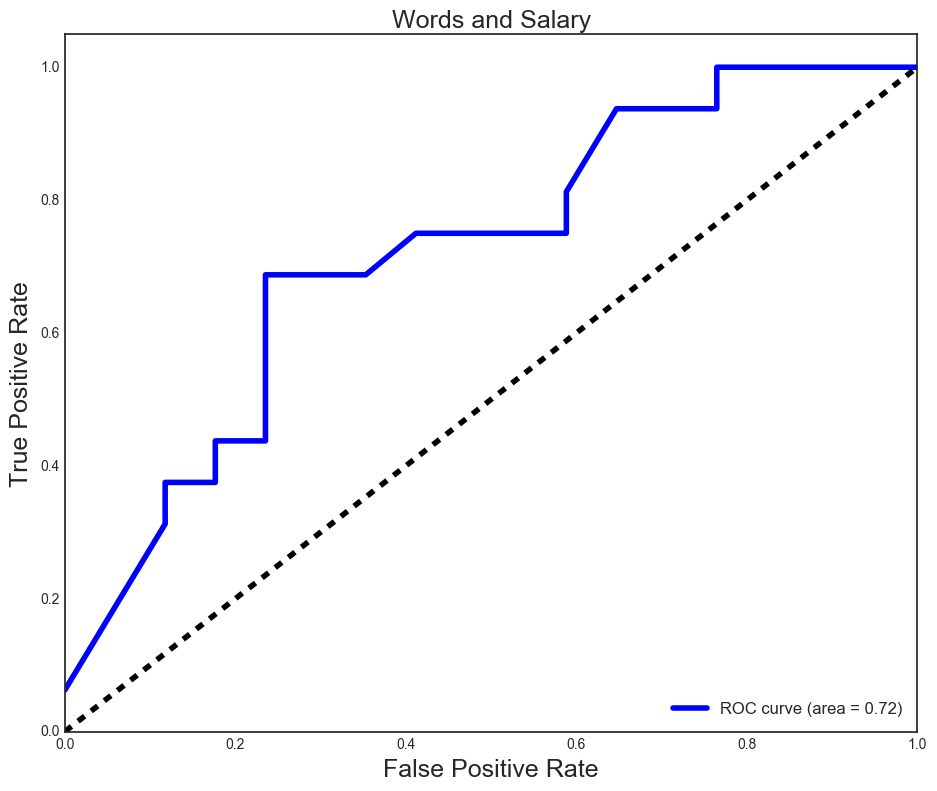

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline


Y_score = logreg.decision_function(X_test)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(Y_test, Y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Words and Salary', fontsize=18)
plt.legend(loc="lower right")
plt.show()

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy, AUC, precision and recall of the model. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

In [26]:
# ## YOUR CODE HERE
# use cross-validation for find score
from sklearn.cross_validation import cross_val_score

# Perform 6-fold cross validation
scores = cross_val_score(logreg, X, y, cv=6, scoring = 'accuracy')  #default MSE
print "accuracy:", scores

scores = cross_val_score(logreg, X, y, cv=6, scoring = 'precision')
print "precision:", scores

scores = cross_val_score(logreg, X, y, cv=6, scoring = 'recall')
print "recall:", scores

scores = cross_val_score(logreg, X, y, cv=6, scoring = 'roc_auc') 
print "roc_auc:", scores

from sklearn.metrics import classification_report

# precision and recall are done in a class report with f-1 score   
class_report = classification_report(Y_test,Y_pred)
print class_report


accuracy: [ 0.66666667  0.66666667  0.75        0.1875      0.5625      0.625     ]
precision: [ 0.71428571  0.6         0.66666667  0.14285714  0.57142857  0.75      ]
recall: [ 0.55555556  1.          1.          0.125       0.5         0.375     ]
roc_auc: [ 0.7962963   0.60493827  0.984375    0.203125    0.703125    0.703125  ]
             precision    recall  f1-score   support

          0       0.71      0.59      0.65        17
          1       0.63      0.75      0.69        16

avg / total       0.67      0.67      0.66        33



#### Compare L1 and L2 regularization for this logistic regression model. What effect does this have on the coefficients learned?

In [28]:
## YOUR CODE HERE
logreg_l1 = LogisticRegression("l1")

logreg_l1.fit(X,y)

logreg_l1.coef_

array([[-0.75813816,  0.14354499,  0.94477414,  1.00674353, -0.48997549,
        -0.49138637,  0.        ,  0.00819593, -1.5433151 ,  0.        ,
         0.        ]])

In [29]:
## YOUR CODE HERE
logreg_l2 = LogisticRegression("l2")

logreg_l2.fit(X,y)

logreg_l2.coef_

array([[-0.7347751 ,  0.33686232,  0.91082889,  1.11726243, -0.58625162,
        -0.44343941,  0.3904681 ,  0.31403139, -1.11871211,  0.21296728,
        -0.17359217]])

#### Continue to incorporate other text features from the title or summary that you believe will predict the salary and examine their coefficients

#### Take ~100 scraped entries with salaries. Convert them to use with your model and predict the salary - which entries have the highest predicted salaries?

### BONUS 

#### Bonus: Use Count Vectorizer from scikit-learn to create features from the text summaries. 
- Examine using count or binary features in the model
- Re-evaluate the logistic regression model using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [ ]:
## YOUR CODE HERE

In [ ]:
## YOUR CODE HERE

#### Re-test L1 and L2 regularization. You can use LogisticRegressionCV to find the optimal reguarlization parameters. 
- Re-test what text features are most valuable.  
- How do L1 and L2 change the coefficients?

In [ ]:
## YOUR CODE HERE

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

lrCV = LogisticRegressionCV(Cs=5)
lrCV.fit(X, y)

print lrCV.scores_ #[1].max())
